# Import all the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import metrics
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


# Loading the Airbnb dataset below:

You can download the user_training_dataset_update.csv from the link below:

https://drive.google.com/open?id=1tQGlNvkmGVPGcmQID2NNd5p8bkLBxofM

In [2]:
user_training_dataset_update=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_update.csv")

In [166]:
user_training_dataset_update.head()

,id,date_account_created,timestamp_first_active_cleaned,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,Account_creation_date_day_of_week,first_active_date_month,first_active_date_day,first_active_date_year,first_active_date_dayofweek,age_bucket,Total time spent (in seconds)_fill_null_zero,session count_fill_null_zero,Total time spent (in seconds)_bucket,session count_bucket
0,gxn3p5htnn,2010-06-28,2009-03-19,Unknown,facebook,0,en,direct,direct,untracked,...,0,3,19,2009,3,Unknown,0.0,0.0,Unknown,Unknown
1,820tgsjxq7,2011-05-25,2009-05-23,MALE,facebook,0,en,seo,google,untracked,...,2,5,23,2009,5,"(37.0, 43.0]",0.0,0.0,Unknown,Unknown
2,4ft3gnwmtx,2010-09-28,2009-06-09,FEMALE,basic,3,en,direct,direct,untracked,...,1,6,9,2009,1,"(53.0, 122.0]",0.0,0.0,Unknown,Unknown
3,bjjt8pjhuk,2011-12-05,2009-10-31,FEMALE,facebook,0,en,direct,direct,untracked,...,0,10,31,2009,5,"(37.0, 43.0]",0.0,0.0,Unknown,Unknown
4,87mebub9p4,2010-09-14,2009-12-08,Unknown,basic,0,en,direct,direct,untracked,...,1,12,8,2009,1,"(37.0, 43.0]",0.0,0.0,Unknown,Unknown


# Replace the "-unknown-" with "unknown" for the gender and first_browser fields

In [3]:
user_training_dataset_update_binary_classfication=user_training_dataset_update.copy()
user_training_dataset_update_binary_classfication.loc[user_training_dataset_update_binary_classfication['first_browser']=='-unknown-', 'first_browser']='Unknown'
user_training_dataset_update_binary_classfication.loc[user_training_dataset_update_binary_classfication['gender']=='-unknown-', 'gender']='Unknown'



In [4]:
del user_training_dataset_update_binary_classfication['country_destination']
del user_training_dataset_update_binary_classfication['Account_creation_before_booking_flag']

# For session count and total time spent, create two additional fields to fill the null value for average number

In [5]:
total_time_spent_mean=user_training_dataset_update_binary_classfication.loc[user_training_dataset_update_binary_classfication['Total time spent (in seconds)_fill_null_zero']!=0,'Total time spent (in seconds)_fill_null_zero'].mean()
session_count_mean=user_training_dataset_update_binary_classfication.loc[user_training_dataset_update_binary_classfication['session count_fill_null_zero']!=0,'session count_fill_null_zero'].mean()
user_training_dataset_update_binary_classfication['Total time spent (in seconds)_fill_null_mean']=user_training_dataset_update_binary_classfication['Total time spent (in seconds)_fill_null_zero'].replace(0, total_time_spent_mean)
user_training_dataset_update_binary_classfication['session count_fill_null_mean']=user_training_dataset_update_binary_classfication['session count_fill_null_zero'].replace(0, session_count_mean)

In [6]:
user_training_dataset_update_binary_classfication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Columns: 391 entries, id to session count_fill_null_mean
dtypes: bool(1), float64(366), int64(9), object(15)
memory usage: 635.3+ MB


# Define function to get dummy variables from all the categorical variables:

In [7]:
def func_get_dummy_variables_for_categorical_variables(dataset, variable_name):
    
    dummy_variables_series=pd.get_dummies(dataset[variable_name])
    dummy_variables_series_df=pd.DataFrame(dummy_variables_series)
    
    for column in dummy_variables_series_df.columns:
        new_column_name=variable_name+'_'+str(column)
        if new_column_name in dataset.columns:
            del dataset[new_column_name]
        
        dummy_variables_series_df=dummy_variables_series_df.rename(columns={column: new_column_name})
        
        
    del dataset[variable_name]
    #del dummy_variables_series_df[dummy_variables_series_df.columns[-1]]
    return dummy_variables_series_df

# Only include the columns that would be used for the model

In [8]:
user_training_dataset_update_binary_classfication1=user_training_dataset_update_binary_classfication.copy()

In [9]:
session_count_by_action_name_column_list=user_training_dataset_update_binary_classfication1.columns[user_training_dataset_update_binary_classfication1.columns.str.contains('action')]

In [10]:
user_training_dataset_update_binary_classfication1.columns

Index(['id', 'date_account_created', 'timestamp_first_active_cleaned',
       'gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       ...
       'first_active_date_day', 'first_active_date_year',
       'first_active_date_dayofweek', 'age_bucket',
       'Total time spent (in seconds)_fill_null_zero',
       'session count_fill_null_zero', 'Total time spent (in seconds)_bucket',
       'session count_bucket', 'Total time spent (in seconds)_fill_null_mean',
       'session count_fill_null_mean'],
      dtype='object', length=391)

In [11]:
feature_to_include_list=[
#Categorical Variables:
'gender',
'signup_method',
'signup_flow',
'language',
'affiliate_channel',
'affiliate_provider',
'first_affiliate_tracked',
'signup_app',
'first_device_type',
'first_browser',
'trip_booking_flag',

# Buckets created for age, total time spent and session count:
'age_bucket',
'Total time spent (in seconds)_bucket',                    
'session count_bucket',
    
#Continuous Variables:
'Total time spent (in seconds)_fill_null_zero',  
'session count_fill_null_zero',
'Total time spent (in seconds)_fill_null_mean', 
'session count_fill_null_mean'  ,

# Year, month, date, day of the week derived from the account creation date:
'Account_creation_date_year',
'Account_creation_date_month',
'Account_creation_date_day',
'Account_creation_date_day_of_week',

# Year, month, date, day of the week derived from the first active date:
'first_active_date_year',
'first_active_date_month',
'first_active_date_day',
'first_active_date_dayofweek' ]

# Append all the session count by action type variables to the feature list:

In [12]:
for c in session_count_by_action_name_column_list:
    feature_to_include_list.append(c)

In [13]:
user_training_dataset_update_binary_classfication1=user_training_dataset_update_binary_classfication1[feature_to_include_list]                                                                                                   

# Define the list of the categorical variables and convert the categorical variables to dummy variables through one hot encoding:

In [14]:
Categorical_variable_list=['gender',
'signup_method',
'signup_flow',
'language',
'affiliate_channel',
'affiliate_provider',
'first_affiliate_tracked',
'signup_app',
'first_device_type',
'first_browser',
'age_bucket',
'Total time spent (in seconds)_bucket',                   
'session count_bucket',
'Account_creation_date_year',
'Account_creation_date_month', 'Account_creation_date_day',
'Account_creation_date_day_of_week', 'first_active_date_year',
'first_active_date_month', 'first_active_date_day',
'first_active_date_dayofweek']

# Create dummy variables for the categorical variables:

In [15]:
for variable_name in Categorical_variable_list:
    df_dummy=func_get_dummy_variables_for_categorical_variables(user_training_dataset_update_binary_classfication1, variable_name)
    user_training_dataset_update_binary_classfication1=user_training_dataset_update_binary_classfication1.merge(df_dummy, on=None, left_index=True, right_index=True)

In [16]:
user_training_dataset_update_binary_classfication1.shape

(213451, 648)

# Check if there's any null value in the user_training_dataset_update_binary_classfication1 dataset:

In [17]:
for column in user_training_dataset_update_binary_classfication1.columns:
    row_count=user_training_dataset_update_binary_classfication1[column].count()
    if row_count<213451:
        print(column)
    

# There's no column with null value after having preprocessed the data.

# Define the feature list:

In [18]:
feature_list=list(user_training_dataset_update_binary_classfication1.columns)

# For age, session count and total time spent, I have three sets of variables: bucketized features,  continuos features with null values filled with zero and continuous features with null values filled with average numbers

# For the Logistic regression, we are going to bucketized fields for the field with missing value including total time spent and session count:

For the total time spend and session count, use the bucket variables instead of the continuous variables in this case.

So need to delete the following variables from the feature list:
- Total time spent (in seconds)_fill_null_zero  
- session count_fill_null_zero  
- Total time spent (in seconds)_fill_null_mean
- session count_fill_null_mean


In [19]:
feature_list.remove('Total time spent (in seconds)_fill_null_zero')
feature_list.remove('session count_fill_null_zero')
feature_list.remove('Total time spent (in seconds)_fill_null_mean')
feature_list.remove('session count_fill_null_mean')

# remove the trip_booking_flag variable  (dependent variable)

In [20]:
feature_list.remove('trip_booking_flag')

# Define the label and feature for logistic regression:

In [21]:
y,X=user_training_dataset_update_binary_classfication1.trip_booking_flag, user_training_dataset_update_binary_classfication1[feature_list]

# Split the data into training set and testing set:

In [22]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

# Create training and testing set (testing set 20% training set 80%):

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [24]:
print(X.shape) 
print(X_train.shape) 
print(X_test.shape) 
print(y.shape) 
print(y_train.shape) 
print(y_test.shape) 

(213451, 643)
(170760, 643)
(42691, 643)
(213451,)
(170760,)
(42691,)


#  Develop binary classification model. Use trip_booking_flag as the label and rest of the variables as features


# Use Logistic Regression to fit the model:

# Summary of the model performance on the testing set:
- Accuracy Score:  71%
- Precision Score: 69%
- Recall Score:  58%
- Roc Auc Score:  69%
- F1 Score:  63%

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import metrics
import seaborn as sns

In [220]:
model_logistic_regression_binary_clf=LogisticRegression(random_state=123).fit(X_train,y_train)
cross_val_score(model_logistic_regression_binary_clf, X_train,y_train, cv=5).mean()

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

0.7127606047172956

Cross validataion accuracy score: 71%

Model Performance on the training set:

In [221]:
print("Accuracy Score: ", cross_val_score(model_logistic_regression_binary_clf, X_train,y_train, cv=5).mean())
print("Precision Score: ", cross_val_score(model_logistic_regression_binary_clf, X_train,y_train, cv=5, scoring='precision').mean())
print("Recall Score: ", cross_val_score(model_logistic_regression_binary_clf,X_train,y_train, cv=5, scoring='recall').mean())
print("F1 Score: ", cross_val_score(model_logistic_regression_binary_clf, X_train,y_train, cv=5, scoring='f1').mean())
print("ROC AUC Score: ", cross_val_score(model_logistic_regression_binary_clf, X_train,y_train, cv=5, scoring='roc_auc').mean())

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

Accuracy Score:  0.7127606047172956


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

Precision Score:  0.684507536173796


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

Recall Score:  0.5747052985131211


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

F1 Score:  0.624811709943522


C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-package

ROC AUC Score:  0.7705511073484941


# Create the ROC AUC Curve

In [222]:
y_pred_proba = np.array(list(zip(*model_logistic_regression_binary_clf.predict_proba(X_train))))[1]

In [223]:
fpr, tpr, threshold=roc_curve(y_train, y_pred_proba)

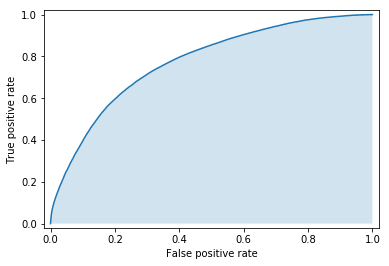

In [224]:
y_pred_proba
eps = .02
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
f = plt.plot(fpr, tpr)  # plot ROC curve
f = plt.fill_between(fpr, tpr, 0, alpha=.2)  # fill AUC
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)
f = plt.xlabel('False positive rate'), plt.ylabel('True positive rate')


Model Performance on the testing set:

In [225]:
y_pred_class= model_logistic_regression_binary_clf.predict(X_test)
Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
Precision_score=metrics.precision_score(y_test, y_pred_class)
Recall_score=metrics.recall_score(y_test, y_pred_class)
f1_score=metrics.f1_score(y_test, y_pred_class)
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)

print('Accuracy Score: ', Accuracy_score)
print('Precision Score: ', Precision_score)
print('Recall Score: ', Recall_score)
print('Roc Auc Score: ', roc_auc_score)
print('F1 Score: ', f1_score)


Accuracy Score:  0.7138741186666979
Precision Score:  0.6877293654500567
Recall Score:  0.5776818742293465
Roc Auc Score:  0.6946721576869295
F1 Score:  0.6279204361997014


In [226]:
y_pred_proba_testing_set=np.array(list(zip(*model_logistic_regression_binary_clf.predict_proba(X_test)))[1])

In [227]:
fpr_test, tpr_test, threshold_test=roc_curve(y_test, y_pred_proba_testing_set)

Text(0.5, 1.0, 'Model Performance Evaluation: Roc Auc Curve for testing set')

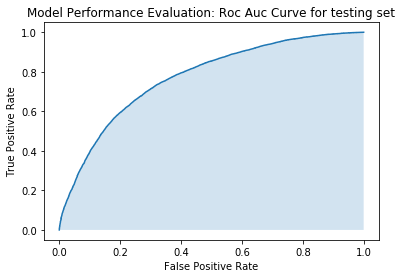

In [228]:
plt.plot(fpr_test, tpr_test)
plt.fill_between(fpr_test, tpr_test, alpha=0.2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Performance Evaluation: Roc Auc Curve for testing set")

# Model Prediction:

In [229]:
model_logistic_regression_binary_clf.predict(X_train)

array([ True, False,  True, ..., False, False, False])

In [230]:
prediction_logistic_regression=pd.Series(model_logistic_regression_binary_clf.predict(X_train))

In [231]:
prediction_probability_logistic_regression=list(zip(*model_logistic_regression_binary_clf.predict_proba(X_train)))[1]

Below is the distribution of the prediction probability:

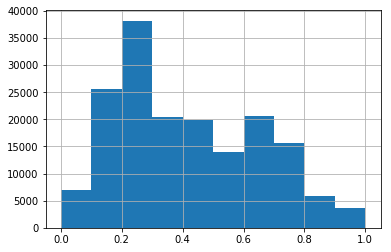

In [232]:
pd.Series(list(prediction_probability_logistic_regression)).hist()

Logistic Regression Coefficient:

In [233]:
logistic_regression_coefficient_df=pd.DataFrame(list(zip(feature_list, model_logistic_regression_binary_clf.coef_[0])), columns=['feature_name', 'beta'])

In [234]:
logistic_regression_coefficient_df.head()

,feature_name,beta
0,Session Count by action name_10,0.039827
1,Session Count by action name_11,-0.056956
2,Session Count by action name_12,0.076374
3,Session Count by action name_15,0.174491
4,Session Count by action name_about_us,-0.031364


# Sort beta to get important coefficients:

In [235]:
logistic_regression_coefficient_df.sort_values(by='beta', ascending=False).head(10)

,feature_name,beta
250,Session Count by action name_receipt,1.591147
339,Session Count by action name_update_country_of...,1.509144
460,first_browser_Camino,1.410136
17,Session Count by action name_add_guests,1.360838
167,Session Count by action name_load_more,1.286323
576,Account_creation_date_day_28,1.248867
212,Session Count by action name_pending,1.158242
630,first_active_date_day_26,1.135692
301,Session Count by action name_social-media,1.027054
369,signup_flow_3,1.022767


Add a column called coefficient direction with two value: "Positive" and "Negative"

In [236]:
logistic_regression_coefficient_df['coefficient_direction']=''
logistic_regression_coefficient_df.loc[logistic_regression_coefficient_df['beta']<=0 ,'coefficient_direction']='Negative'
logistic_regression_coefficient_df.loc[logistic_regression_coefficient_df['beta']>0 ,'coefficient_direction']='Positive'

In [237]:
logistic_regression_coefficient_df['coefficient_direction'].unique()

array(['Positive', 'Negative'], dtype=object)

In [238]:
logistic_regression_coefficient_df['odd_coefficient']=np.exp(logistic_regression_coefficient_df['beta'])

In [239]:
logistic_regression_coefficient_df.sort_values(by='odd_coefficient', ascending=False, inplace=True)

In [240]:
logistic_regression_coefficient_df.set_index('feature_name', inplace=True)

Display the top 15 most important features to classify the users into booking versus not booking:

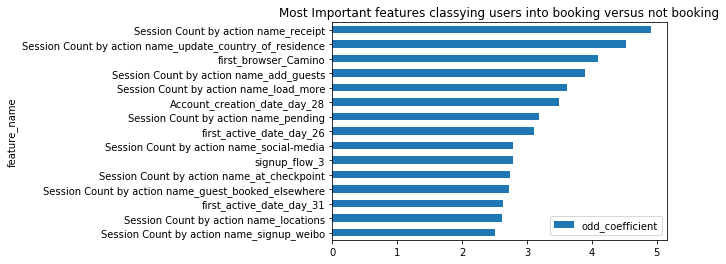

In [241]:
f1=logistic_regression_coefficient_df[:15][['odd_coefficient']].sort_values(by='odd_coefficient',ascending=True).plot(kind='barh', title="Most Important features classying users into booking versus not booking")

Display the top 15 most important positive features to classify the users into booking versus not booking:

In [242]:
logistic_regression_coefficient_df_positive=logistic_regression_coefficient_df.loc[logistic_regression_coefficient_df['coefficient_direction']=='Positive']
logistic_regression_coefficient_df_positive.sort_values(by='odd_coefficient', ascending=False, inplace=True)

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


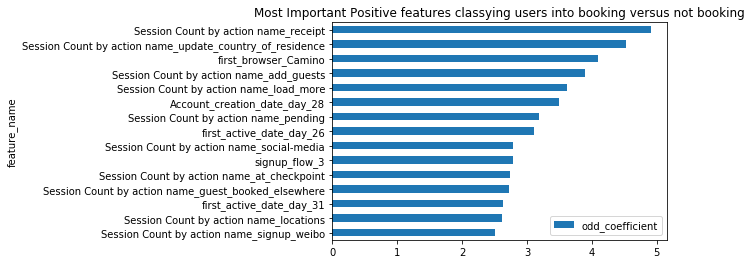

In [243]:
f2=logistic_regression_coefficient_df_positive[:15][['odd_coefficient']].sort_values(by='odd_coefficient',ascending=True).plot(kind='barh', title="Most Important Positive features classying users into booking versus not booking")

Display the top 15 most important negative features to classify the users into booking versus not booking:

In [244]:
logistic_regression_coefficient_df_negative=logistic_regression_coefficient_df.loc[logistic_regression_coefficient_df['coefficient_direction']=='Negative']
logistic_regression_coefficient_df_negative.sort_values(by='odd_coefficient', ascending=False, inplace=True)

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


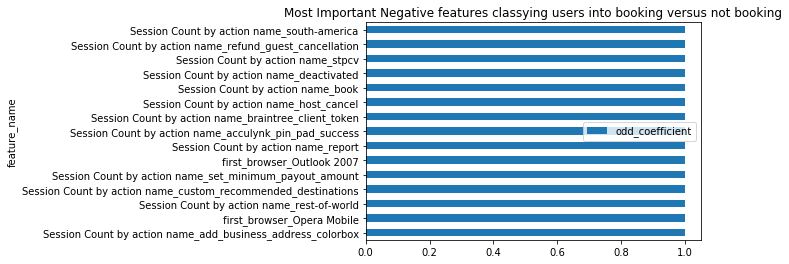

In [245]:
f3=logistic_regression_coefficient_df_negative[:15][['odd_coefficient']].sort_values(by='odd_coefficient',ascending=True).plot(kind='barh', title="Most Important Negative features classying users into booking versus not booking")

# Try Random Forest with a number of trees:

Below is the performance summary for random forest:
- accuracy score:  73%
- precision score: 69%
- recall score:  62%
- roc auc score: 71%

# Define the features and label: for the tree-based models, I'm going to try out the continuous features instead of bucketized features for training the model

In [25]:
feature_list1=list(user_training_dataset_update_binary_classfication1.columns)

In [26]:
bucketized_feature=list(user_training_dataset_update_binary_classfication1.columns[user_training_dataset_update_binary_classfication1.columns.str.contains('bucket')])

In [27]:
age_bucketized_feature=list(user_training_dataset_update_binary_classfication1.columns[user_training_dataset_update_binary_classfication1.columns.str.contains('age_bucket')])

In [28]:
for feature in age_bucketized_feature:
    bucketized_feature.remove(feature)

# Remove the bucketized features from the feature list

In [29]:
feature_list1.remove('trip_booking_flag')

In [30]:
for feature in bucketized_feature:
    feature_list1.remove(feature)

# Create two sets of feature lists: 
- one list just including total time spent and session count with values filled with zero  
- another list just including total time spent and session count with values filled with average numbers

In [31]:
feature_list1.remove('Total time spent (in seconds)_fill_null_mean')
feature_list1.remove('session count_fill_null_mean')

In [163]:
y,X=user_training_dataset_update_binary_classfication1.trip_booking_flag, user_training_dataset_update_binary_classfication1[feature_list1]

Create test and train set and use the training dataset for training the model:

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
print("Shape of features of training dataset: ", X_train.shape)
print("Shape of features of testing dataset: ", X_test.shape)
print("Shape of labels of training dataset :", y_train.shape)
print("Shape of labels of testing dataset: ", y_test.shape)

Shape of features of training dataset:  (170760, 628)
Shape of features of testing dataset:  (42691, 628)
Shape of labels of training dataset : (170760,)
Shape of labels of testing dataset:  (42691,)


# Train the Random forest model on the training dataset and append the performance metrics based on the testing dataset into the score dataframe.

When fitting the model, adjust the n_estimators and criterion to try out different number of trees and different algorithms for splitting nodes: 
- Algorithm: Gini and Entropy  
- Different number of estimators 10, 20, 50, 100, 150.

In [196]:
%time
random_forest_score=[]
n_estimators_list=[10, 20, 50, 100, 150]
for n_estimator in n_estimators_list:
    for criterion in ['gini', 'entropy']:
        start_time=time.time()
        model_random_forest_binary_clf=RandomForestClassifier(n_estimators=n_estimator,criterion=criterion, n_jobs=-1).fit(X_train,y_train)
        end_time=time.time()
        runing_time=end_time-start_time
        y_pred_class=model_random_forest_binary_clf.predict(X_test)
        Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
        Precision_score=metrics.precision_score(y_test, y_pred_class)
        Recall_score=metrics.recall_score(y_test, y_pred_class)
        f1_score=metrics.f1_score(y_test, y_pred_class)
        roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)
        
        random_forest_score.append(dict(n_estimator=n_estimator, criterion=criterion,  Accuracy=Accuracy_score, Precision=Precision_score, Recall=Recall_score, f1= f1_score,roc_auc=roc_auc_score, runing_time=runing_time ))
        
random_forest_score=pd.DataFrame(random_forest_score)


Wall time: 0 ns


# Below is the output of the random forest classfication model:

 - Entropy is doing better than gini
 - The higher the estimators the bettter the performance is
 - Based on the output dataframe, I decided to pick entropy algorithm with 150 trees

In [197]:
random_forest_score

,Accuracy,Precision,Recall,criterion,f1,n_estimator,roc_auc,runing_time
0,0.681104,0.639368,0.544151,gini,0.587929,10,0.661823,11.033520
1,0.681385,0.640708,0.541629,entropy,0.587017,10,0.661709,10.939799
2,0.691200,0.644383,0.583259,gini,0.612299,20,0.676003,18.693420
3,0.690216,0.642167,0.584996,entropy,0.612250,20,0.675402,18.986614
4,0.701483,0.651221,0.615755,gini,0.632992,50,0.689414,44.481330
5,0.700639,0.651247,0.611329,entropy,0.630657,50,0.688066,46.465674
6,0.702256,0.650178,0.623039,gini,0.636319,100,0.691103,87.971003
7,0.704130,0.652232,0.626177,entropy,0.638939,100,0.693155,96.461012
8,0.704715,0.652703,0.627689,gini,0.639952,150,0.693871,132.841558
9,0.705207,0.653539,0.627577,entropy,0.640295,150,0.694278,138.874281


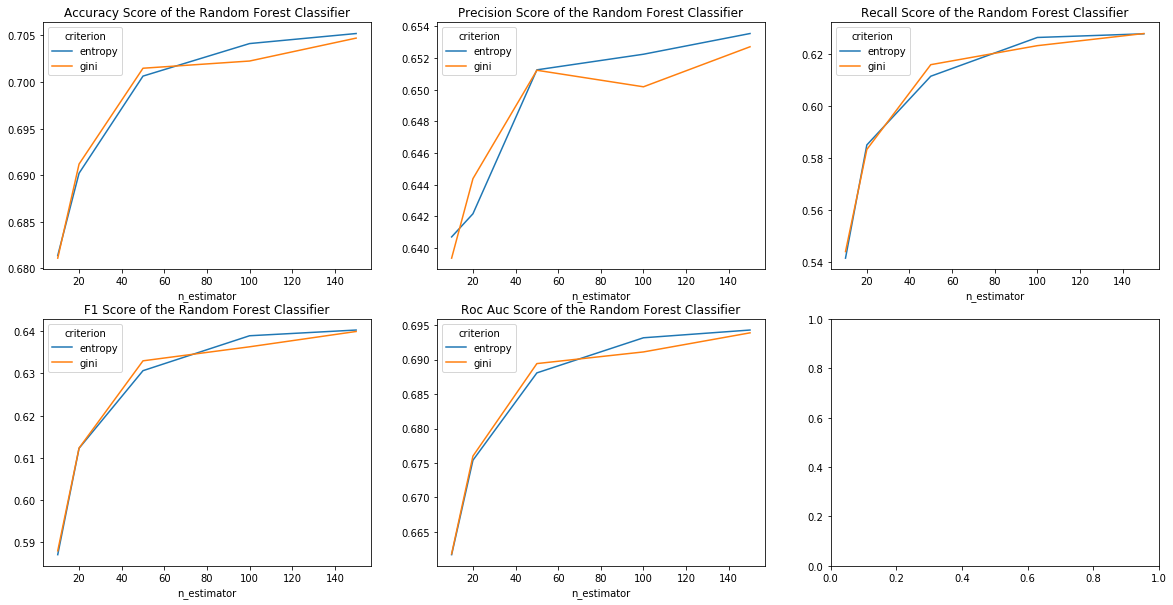

In [198]:
fig, axes=plt.subplots(2,3,figsize=(20, 10))
random_forest_score.groupby(['n_estimator', 'criterion'])['Accuracy'].mean().unstack().plot(title="Accuracy Score of the Random Forest Classifier", ax=axes[0,0])
random_forest_score.groupby(['n_estimator', 'criterion'])['Precision'].mean().unstack().plot(title="Precision Score of the Random Forest Classifier", ax=axes[0,1])
random_forest_score.groupby(['n_estimator', 'criterion'])['Recall'].mean().unstack().plot(title="Recall Score of the Random Forest Classifier", ax=axes[0,2])
random_forest_score.groupby(['n_estimator', 'criterion'])['f1'].mean().unstack().plot(title="F1 Score of the Random Forest Classifier", ax=axes[1,0])
random_forest_score.groupby(['n_estimator', 'criterion'])['roc_auc'].mean().unstack().plot(title="Roc Auc Score of the Random Forest Classifier", ax=axes[1,1])


# Generate ROC AUC Curve:

In [199]:
y_pred_proba=np.array(list(zip(*model_random_forest_binary_clf.predict_proba(X_test))))[1]

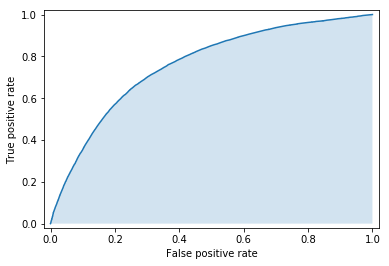

In [200]:
y_pred_proba
eps = .02
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
f = plt.plot(fpr, tpr)  # plot ROC curve
f = plt.fill_between(fpr, tpr, 0, alpha=.2)  # fill AUC
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)
f = plt.xlabel('False positive rate'), plt.ylabel('True positive rate')


Get the feature importance out of the model_random_forest_binary_clf classification model:

In [201]:
model_random_forest_binary_feature_importance_df=pd.DataFrame(list(zip(feature_list1, model_random_forest_binary_clf.feature_importances_)), columns=['feature name', 'feature importance'])

In [202]:
model_random_forest_binary_feature_importance_df=model_random_forest_binary_feature_importance_df.sort_values(by='feature importance', ascending=False)
model_random_forest_binary_feature_importance_df.set_index('feature name', inplace=True)

# Important features from the random forest:

Out of all the features used in the random forest, Belw are the 15 most important features. 

Some of the importance features include age_bucket_unknonw, gender_unknown, first_browser_chrome, first_affiliated_tracked_untracked and signup_method_facebook.

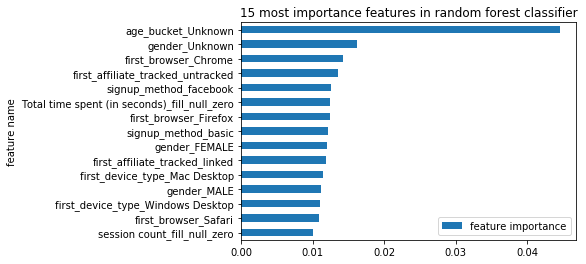

In [282]:
model_random_forest_binary_feature_importance_df[:15]. sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most importance features in random forest classifier")

# Try Random Search with Cross Validation to get the best hyper parameter tuning:

Create initial range of values for the hyperparameter random search:

In [36]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 500, num = 50)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [150,
                  157,
                  164,
                  171,
                  178,
                  185,
                  192,
                  200,
                  207,
                  214,
                  221,
                  228,
                  235,
                  242,
                  250,
                  257,
                  264,
                  271,
                  278,
                  285,
                  292,
                  300,
                  307,
                  314,
                  321,
                  328,
                  335,
                  342,
                  350,
                  357,
                  364,
                  371,
                  378,
                  385,
                  392,
                  400,
         

Use the Randomized Search CV to get the optimal hyperparameter:

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring="roc_auc", 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.7min finished


In [38]:
rf_random.best_params_

{'n_estimators': 435,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': None,
 'bootstrap': True}

In [39]:
best_random = rf_random.best_estimator_

# Create a function for performance evaluation:

In [40]:
def model_evaluation(model, test_features, test_label):
    y_pred_class=model.predict(test_features)
    
    from sklearn import metrics
    accuracy_score=metrics.accuracy_score(test_label, y_pred_class)
    precision_score=metrics.precision_score(test_label, y_pred_class)
    recall_score=metrics.recall_score(test_label, y_pred_class)
    roc_auc_score=metrics.roc_auc_score(test_label, y_pred_class)
    
    print("Model Performance:")
    
    print("accuracy score: ", accuracy_score)
    print("precision score: ", precision_score)
    print("recall score: ", recall_score)
    print("roc auc score:", roc_auc_score)
    

# The roc auc score gets much better after using the recommended hyperparameter:

In [41]:
best_random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=435, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
model_evaluation(best_random, X_test, y_test)

Model Performance:
accuracy score:  0.7239699234030592
precision score:  0.6861950380741833
recall score:  0.6260645450470641
roc auc score: 0.7101864004468907


# Given the best hyperparameter recommeneded by the randomized search, narrow down the range for finalize the final hyperparameters to use for the model.

- Below are the hyperpatamers recommended by the randomized search:

bootstrap: True,

max_depth: None,

min_samples_leaf: 4,

min_samples_split: 10,

n_estimators: 435


In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [ True],
     'max_depth': [None],
     'min_samples_leaf': [4],
     'min_samples_split': [10,15],
     'n_estimators': [435, 440]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [45]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 36.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 36.7min finished


Below are the parameters recommended by by the grid search:

In [47]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 435}

The Best grid random forest model performance on testing set:

In [82]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=435, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [49]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=435, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [83]:
best_grid_search_random_forest=grid_search.best_estimator_

Best Grid Random Forest model performance on training and  testing dataset:

In [50]:
model_evaluation(best_grid, X_train, y_train)

Model Performance:
accuracy score:  0.7845806980557508
precision score:  0.7665780017732978
recall score:  0.6935125246270757
roc auc score: 0.7715004950116321


In [51]:
model_evaluation(best_grid, X_test, y_test)

Model Performance:
accuracy score:  0.7243447096577733
precision score:  0.6865488463426608
recall score:  0.6268489466606902
roc auc score: 0.7106188540412093


# Generate Precision Recall Plot:

In [53]:
from sklearn.metrics import precision_recall_curve

Best_random_forest_classifier=best_grid

Best_random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=435, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
y_pred_proba = np.array(list(zip(*Best_random_forest_classifier.predict_proba(X_train))))[1]

In [55]:
precisions, recalls, thresholds =precision_recall_curve(y_train, y_pred_proba)

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, threholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

In [57]:
df_precision_recall=pd.DataFrame({'threshold':thresholds[0: len(thresholds)],'precisions': precisions[0:len(thresholds)], 'recall': recalls[0:len(thresholds)]})

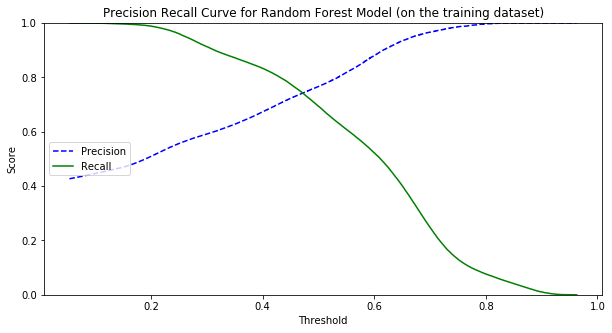

In [58]:
plt.rcParams["figure.figsize"] = (10,5)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precision Recall Curve for Random Forest Model (on the training dataset)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

# Below is the performance after adjusting the threshold on testing set:

In [59]:
y_pred_proba_test = np.array(list(zip(*Best_random_forest_classifier.predict_proba(X_test))))[1]

In [61]:
from sklearn.metrics import accuracy_score

In [62]:
threholds=np.linspace(0.4, 0.6, 20)
accuracy_score_threshold_list=[]
precision_score_threshold_list=[]
recall_score_threshold_list=[]
roc_auc_score_threshold_list=[]
for threshold in threholds:
    y_prediction_adjusted_thredhold_45_testset=y_pred_proba_test>=threshold
    accuracy_score_threshold=accuracy_score(y_test,y_prediction_adjusted_thredhold_45_testset )
    precision_score_threshold=precision_score(y_test, y_prediction_adjusted_thredhold_45_testset) 
    recall_score_threshold=recall_score(y_test,y_prediction_adjusted_thredhold_45_testset)
    roc_auc_score_threshold=roc_auc_score(y_test,y_prediction_adjusted_thredhold_45_testset)
    accuracy_score_threshold_list.append(accuracy_score_threshold)
    precision_score_threshold_list.append(precision_score_threshold)
    recall_score_threshold_list.append(recall_score_threshold)
    roc_auc_score_threshold_list.append(roc_auc_score_threshold)

threshold_adjustment_testing_dataset_performance=pd.DataFrame({'threshold': threholds, "accuracy score":accuracy_score_threshold_list, "precision score": precision_score_threshold_list, "recall score":recall_score_threshold_list, "roc auc score": roc_auc_score_threshold_list}   )
threshold_adjustment_testing_dataset_performance.set_index('threshold', inplace=True)

In [63]:
threshold_adjustment_testing_dataset_performance.head()

,accuracy score,precision score,recall score,roc auc score
threshold,,,,
0.400000,0.703802,0.615504,0.776726,0.714068
0.410526,0.707901,0.622909,0.763559,0.715737
0.421053,0.711883,0.630738,0.749832,0.717226
0.431579,0.714998,0.638002,0.735769,0.717923
0.442105,0.718184,0.646046,0.720865,0.718562


In [66]:
threshold_adjustment_testing_dataset_performance.head()

,accuracy score,precision score,recall score,roc auc score
threshold,,,,
0.400000,0.703802,0.615504,0.776726,0.714068
0.410526,0.707901,0.622909,0.763559,0.715737
0.421053,0.711883,0.630738,0.749832,0.717226
0.431579,0.714998,0.638002,0.735769,0.717923
0.442105,0.718184,0.646046,0.720865,0.718562


# Chart out the performance of the model based by trying out difference threshold:

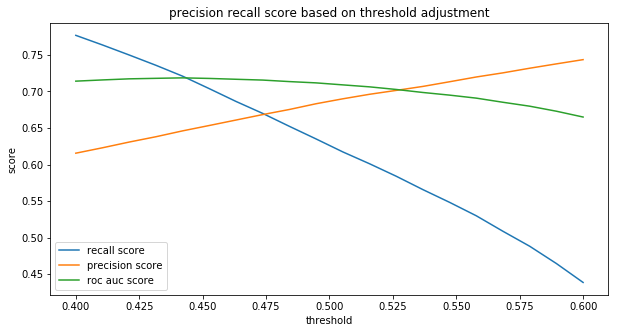

In [64]:
threshold_adjustment_testing_dataset_performance['recall score'].plot()
threshold_adjustment_testing_dataset_performance['precision score'].plot()
threshold_adjustment_testing_dataset_performance['roc auc score'].plot()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title("precision recall score based on threshold adjustment")
plt.legend()
plt.show()

Since  the first phase of the model, I'm going to prioritize on enhance the recall score to make sure as many as samples will not be classified as NDF, I'm going to pick 0.442 as threshold instead of 0.5 for the model.

# Feature Importance:

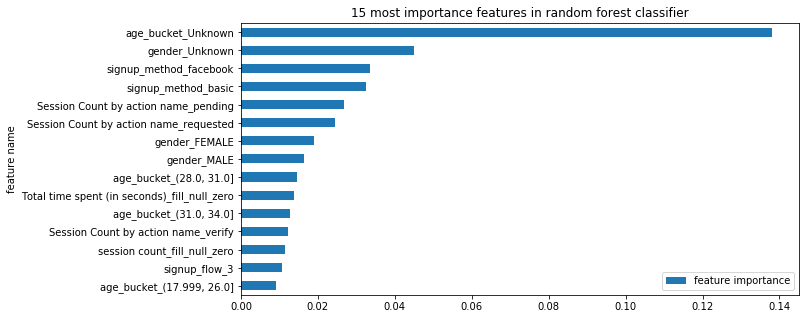

In [67]:
model_bestgrid_random_forest_binary_feature_importance_df=pd.DataFrame(list(zip(feature_list1, best_grid.feature_importances_)), columns=['feature name', 'feature importance'])
model_bestgrid_random_forest_binary_feature_importance_df=model_bestgrid_random_forest_binary_feature_importance_df.sort_values(by='feature importance', ascending=False)
model_bestgrid_random_forest_binary_feature_importance_df.set_index('feature name', inplace=True)
model_bestgrid_random_forest_binary_feature_importance_df[:15]. sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most importance features in random forest classifier")

# Error Analysis for the random forest classifier:

Create a dataframes for error analysis

In [68]:
threshold=0.442
prediction_y_train=y_pred_proba>=threshold
prediction_y_test=y_pred_proba_test>=threshold
training_set_error=pd.DataFrame(prediction_y_train!=y_train)
testing_set_error=pd.DataFrame(prediction_y_test!=y_test)
training_set_error=training_set_error.loc[training_set_error['trip_booking_flag']==True]
testing_set_error=testing_set_error.loc[testing_set_error['trip_booking_flag']==True]
testing_set_error.columns=['Trip_booking_flag_error_flag']
training_set_error.columns=['Trip_booking_flag_error_flag']
training_testing_error=pd.concat([testing_set_error, training_set_error])
test_training_error_df=pd.merge(user_training_dataset_update, training_testing_error, left_index=True, right_index=True, how='inner')

In [69]:
test_training_error_df['trip_booking_flag'].value_counts()/user_training_dataset_update.shape[0]

False    0.137174
True     0.094279
Name: trip_booking_flag, dtype: float64

In the traning dataset, 9% of the users has been misclassified as False while the users have booked a trip.
14% of the users have been misclassified as True while the users have not booked a True.

In [70]:
test_training_error_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active_cleaned',
       'gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       ...
       'first_active_date_month', 'first_active_date_day',
       'first_active_date_year', 'first_active_date_dayofweek', 'age_bucket',
       'Total time spent (in seconds)_fill_null_zero',
       'session count_fill_null_zero', 'Total time spent (in seconds)_bucket',
       'session count_bucket', 'Trip_booking_flag_error_flag'],
      dtype='object', length=392)

In [71]:
test_training_error_df_misclass_as_False=test_training_error_df.loc[test_training_error_df['trip_booking_flag']==True]
test_training_error_df_misclass_as_True=test_training_error_df.loc[test_training_error_df['trip_booking_flag']==False]

By comparing the actuall gender distribution with the gender/age distribution of the misclassified examples, users with unknown gender or age are less likely to classified as bookers.

Text(0.5, 1.0, 'False Positive gender distribution')

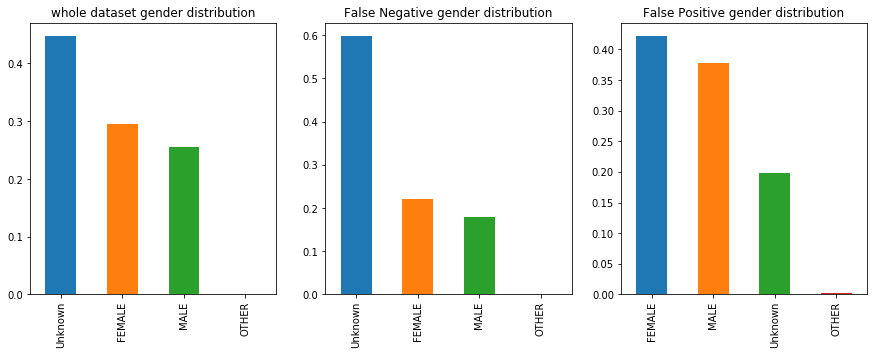

In [73]:
plt.rcParams['figure.figsize']=[15,5]

plt.subplot(1,3,1)
pd.Series(user_training_dataset_update.gender.value_counts()/user_training_dataset_update.shape[0]).plot(kind='bar')
plt.title("whole dataset gender distribution")

plt.subplot(1,3,2)
pd.Series(test_training_error_df_misclass_as_False.gender.value_counts()/test_training_error_df_misclass_as_False.shape[0]).plot(kind='bar')
plt.title("False Negative gender distribution")

plt.subplot(1,3,3)
pd.Series(test_training_error_df_misclass_as_True.gender.value_counts()/test_training_error_df_misclass_as_True.shape[0]).plot(kind='bar')
plt.title("False Positive gender distribution")


Text(0.5, 1.0, 'False Positive age distribution')

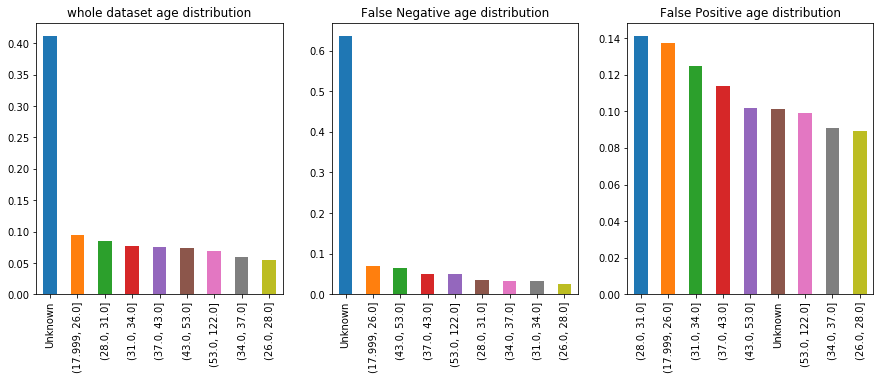

In [482]:
plt.rcParams['figure.figsize']=[15,5]

plt.subplot(1,3,1)
pd.Series(user_training_dataset_update.age_bucket.value_counts()/user_training_dataset_update.shape[0]).plot(kind='bar')
plt.title("whole dataset age distribution")

plt.subplot(1,3,2)
pd.Series(test_training_error_df_misclass_as_False.age_bucket.value_counts()/test_training_error_df_misclass_as_False.shape[0]).plot(kind='bar')
plt.title("False Negative age distribution")

plt.subplot(1,3,3)
pd.Series(test_training_error_df_misclass_as_True.age_bucket.value_counts()/test_training_error_df_misclass_as_True.shape[0]).plot(kind='bar')
plt.title("False Positive age distribution")

By comparing the pending action and requested action session counts, it seems that users with more these types of actions are more likely to be classified as bookers.

In [74]:
print("Total user base sessions count by pending action distribution",'\n',user_training_dataset_update['Session Count by action name_pending'].describe())
print("samples misclassified as non-bookers sessions count by pending action distribution",'\n',test_training_error_df_misclass_as_False['Session Count by action name_pending'].describe())
print("samples misclassified as bookers sessions count by pending action distribution",'\n',test_training_error_df_misclass_as_True['Session Count by action name_pending'].describe())

Total user base sessions count by pending action distribution 
 count    213451.000000
mean          0.048817
std           0.432208
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          76.000000
Name: Session Count by action name_pending, dtype: float64
samples misclassified as non-bookers sessions count by pending action distribution 
 count    20124.000000
mean         0.000547
std          0.025411
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Session Count by action name_pending, dtype: float64
samples misclassified as bookers sessions count by pending action distribution 
 count    29280.000000
mean         0.047404
std          0.343177
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: Session Count by action name_pending, dtype: float64


In [75]:
print("Total user base sessions count by requested action distribution",'\n',user_training_dataset_update['Session Count by action name_requested'].describe())
print("samples misclassified as non-bookers sessions count by requested action distribution",'\n',test_training_error_df_misclass_as_False['Session Count by action name_requested'].describe())
print("samples misclassified as bookers sessions count by requested action distribution",'\n',test_training_error_df_misclass_as_True['Session Count by action name_requested'].describe())

Total user base sessions count by requested action distribution 
 count    213451.000000
mean          0.157427
std           0.954974
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: Session Count by action name_requested, dtype: float64
samples misclassified as non-bookers sessions count by requested action distribution 
 count    20124.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Session Count by action name_requested, dtype: float64
samples misclassified as bookers sessions count by requested action distribution 
 count    29280.000000
mean         0.138388
std          0.860883
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: Session Count by action name_requested, dtype: float64


# Sign up method distribution comparison between whole dataset and misclassified samples

For the signup method, users using basic signup method are more likely to be classified as bookers while users that facebook signup method are more likely to be classified as non-bookers.

Text(0.5, 1.0, 'Positive Postive signup method distribution')

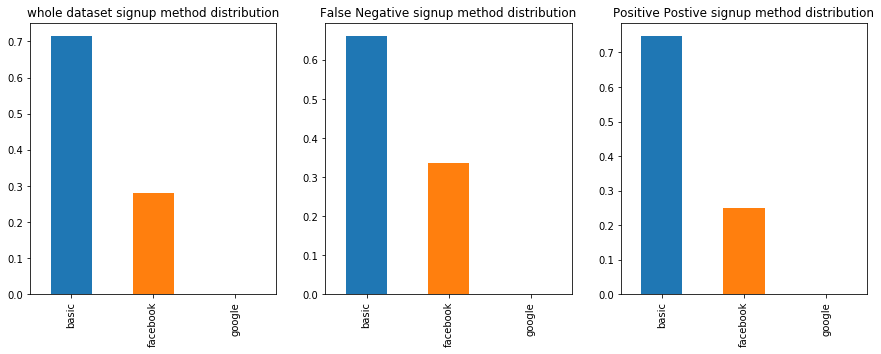

In [76]:
plt.rcParams['figure.figsize']=[15,5]

plt.subplot(1,3,1)
pd.Series(user_training_dataset_update.signup_method.value_counts()/user_training_dataset_update.shape[0]).plot(kind='bar')
plt.title("whole dataset signup method distribution")

plt.subplot(1,3,2)
pd.Series(test_training_error_df_misclass_as_False.signup_method.value_counts()/test_training_error_df_misclass_as_False.shape[0]).plot(kind='bar')
plt.title("False Negative signup method distribution")

plt.subplot(1,3,3)
pd.Series(test_training_error_df_misclass_as_True.signup_method.value_counts()/test_training_error_df_misclass_as_True.shape[0]).plot(kind='bar')
plt.title("Positive Postive signup method distribution")



# Conclusions from the error analysis and possible next steps:
The misclassification here is mainly due to the imbalanced data on the user profiles. For example, there are many users with unknown gender and unknown age (These users are less likely to be classified as bookers), which has limited the capability of the model to make more accurate classifications. Next step would be to only train on the user data with known gender and age.

# Develope a function to fit the model and evaluate the time spent and accuracy of the model:

In [55]:
from sklearn import metrics

In [249]:
def model_fitting_and_evaluation_func(model, x_train, y_train, x_test, y_test):
    n_trees=model.get_params()['n_estimators']
    n_features=x_train.shape[1]
    bootstrap_flag=get_params()['bootstrap']
    max_depth=get_params()['max_depth']
    max_features=get_params()['max_features']
    min_samples_leaf=get_params()['min_samples_leaf']
    min_samples_split=get_params()['min_samples_split']
    
    start_time=time.time()
    clf=model.fit(x_train, y_train)
    end_time=time.time()
    
    running_time=end_time-start_time
    
    y_class_pred=clf.predict(x_test)
    
    #populate all the model performance score:
    accuracy_score=metrics.accuracy_score(y_test, y_class_pred)
    precision_score=metrics.precision_score(y_test, y_class_pred)
    recall_score=metrics.recall_score(y_test, y_class_pred)
    f1_score=metrics.f1_score(y_test, y_class_pred)
    roc_auc_score=metrics.roc_auc_score(y_test, y_class_pred)
    
    performance_dict={'n_trees':n_trees, 'n_features':n_features, 'bootstrap_flag':bootstrap_flag, 'max_depth':max_depth, 'max_features':max_features, 'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split, 'running_time':running_time, 'accuracy_score':accuracy_score, 'precision_score':precision_score,  'f1_score':f1_score, 'roc_auc_score':roc_auc_score }
    performance_dict_df=pd.DataFrame(performance_dict)
    return performance_dict_df
    
    
    
    

In [57]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

# Try XG Boost Classifier for fitting the binary classification:

Model performance summary on the testing set:
- accuracy score: 72%
- precision score:  69%
- recall score:  61%
- roc auc score: 71%

In [492]:
import xgboost as xgb

In [493]:
y,X=user_training_dataset_update_binary_classfication1.trip_booking_flag, user_training_dataset_update_binary_classfication1[feature_list1]


In [494]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=22)

# Convert the dataset into an optimized data structure called Dmatrics that XGBoost Supports

In [495]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]


In [496]:
data_dmatrix=xgb.DMatrix(data=X_train, label=y_train)

In [257]:
xg_clf=xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.5, learning_rate=0.1, alpha=10, n_estimators=20)
params={'objective':"binary:logistic", 'colsample_bytree': 0.3, "learning_rate": 0.1, "alpha":10, "n_estimators":20}

In [258]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Return the model performance output using model_evaluation function:

In [259]:
model_evaluation(xg_clf, X_test, y_test)

Model Performance:
accuracy score:  0.7118830666885292
precision score:  0.6946939921392477
recall score:  0.5545719408337069
roc auc score: 0.6897361575923153


# Plot feature importance:

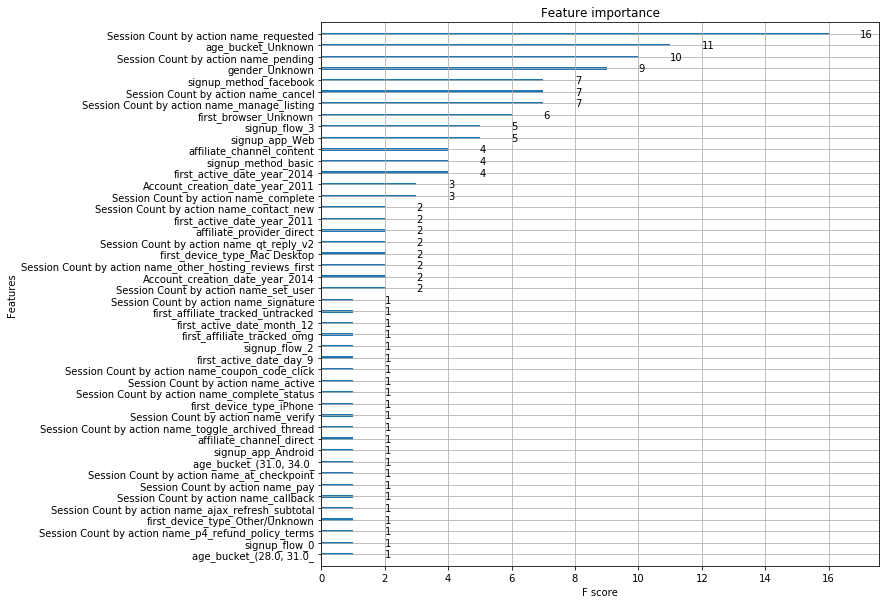

In [265]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize']=[10,15]
plt.show()

# Try Randomized Search on Xgboost:
For the xgboost, I'm only focusing on optimizing two hyper parameters here: n_estimators and colsample by tree

In [266]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

#Set up the range for the parameters: colsample_bytree and n_estimators:

colsample_bytree=[x for x in np.linspace(start=0.2, stop=0.8, num=4)]
n_estimators=[int(x) for x in np.linspace(start=20, stop=500, num=50)]


# Create the random grid
random_grid = {'objective': ["binary:logistic"],
               'colsample_bytree':colsample_bytree,
               'learning_rate':[0.1],
               'alpha':[10],
               'n_estimators':n_estimators}

pprint(random_grid)


{'alpha': [10],
 'colsample_bytree': [0.2, 0.4, 0.6000000000000001, 0.8],
 'learning_rate': [0.1],
 'n_estimators': [20,
                  29,
                  39,
                  49,
                  59,
                  68,
                  78,
                  88,
                  98,
                  108,
                  117,
                  127,
                  137,
                  147,
                  157,
                  166,
                  176,
                  186,
                  196,
                  206,
                  215,
                  225,
                  235,
                  245,
                  255,
                  264,
                  274,
                  284,
                  294,
                  304,
                  313,
                  323,
                  333,
                  343,
                  353,
                  362,
                  372,
                  382,
                  392,
             

In [267]:
#Get rid of the special characters from the feature names:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]


In [268]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgboost_clf = xgb.XGBClassifier(random_state = 22)

# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores

xgboost_random=RandomizedSearchCV(estimator=xgboost_clf, 
                                  param_distributions=random_grid, 
                                  n_iter=10, 
                                  scoring='roc_auc', 
                                  cv=3, verbose=2, 
                                  random_state=22, 
                                  n_jobs=-1, 
                                  return_train_score=True)

# Fit the random search model
xgboost_random.fit(X_train, y_train);


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 1199.5min finished


Get the best parameters from the randomized search for the xgboost:

In [269]:
xgboost_random.best_params_

{'objective': 'binary:logistic',
 'n_estimators': 451,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6000000000000001,
 'alpha': 10}

# Use the test dataset to evaluate the performance of the best parameters:

In [270]:
best_xgboost_random = xgboost_random.best_estimator_

model_evaluation(best_xgboost_random, X_test, y_test)

Model Performance:
accuracy score:  0.7239464992621396
precision score:  0.6943892273164476
recall score:  0.6067346481398476
roc auc score: 0.7074449314442344


In [272]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha': [10],
    'colsample_bytree': [0.6000000000000001],
    'learning_rate': [0.1],
    'n_estimators': [451, 455, 459],
    'objective': ['binary:logistic']
}

# Create a base model
xgboost_clf = xgb.XGBClassifier(random_state = 22)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgboost_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [273]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

grid_search.best_params_

best_grid = grid_search.best_estimator_
model_evaluation(best_grid, X_test, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 67.3min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 83.3min finished


Model Performance:
accuracy score:  0.7238996509803003
precision score:  0.6943251042000641
recall score:  0.60667861945316
roc auc score: 0.7073967907071379


# Below is the best parameters for the xgboost model:

In [274]:
print( grid_search.best_params_)

{'alpha': 10, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'n_estimators': 459, 'objective': 'binary:logistic'}


Show the precision recall curve for the xgboost model:

In [501]:
precisions, recalls, thresholds =precision_recall_curve(y_train, list(zip(*best_grid.predict_proba(X_train)))[1])  

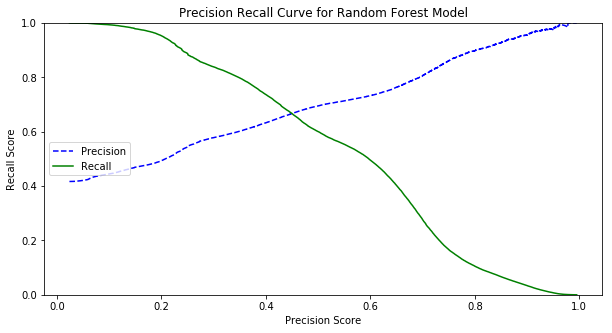

In [502]:
plt.rcParams["figure.figsize"] = (10,5)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precision Recall Curve for Random Forest Model")
plt.xlabel("Precision Score")
plt.ylabel("Recall Score")
plt.show()

# Decide on which threshold to use on the testing dataset for optimizing performance:

In [508]:
thresholds=np.linspace(0.4, 0.6, 20)
accuracy_score_threshold_list1=[]
precision_score_threshold_list1=[]
recall_score_threshold_list1=[]
roc_auc_score_threshold_list1=[]
for threshold in thresholds:
    y_prediction_threshold=list(zip(*best_grid.predict_proba(X_test)))[1]>=threshold
    accuracy_score_threshold=accuracy_score(y_test,y_prediction_threshold )
    precision_score_threshold=precision_score(y_test, y_prediction_threshold) 
    recall_score_threshold=recall_score(y_test,y_prediction_threshold)
    roc_auc_score_threshold=roc_auc_score(y_test,y_prediction_threshold)
    accuracy_score_threshold_list1.append(accuracy_score_threshold)
    precision_score_threshold_list1.append(precision_score_threshold)
    recall_score_threshold_list1.append(recall_score_threshold)
    roc_auc_score_threshold_list1.append(roc_auc_score_threshold)
    
threshold_adjustment_testing_dataset_performance1=pd.DataFrame({'threshold': thresholds, "accuracy score":accuracy_score_threshold_list1, "precision score": precision_score_threshold_list1, "recall score":recall_score_threshold_list1, "roc auc score": roc_auc_score_threshold_list1}   )
threshold_adjustment_testing_dataset_performance1.set_index('threshold', inplace=True)
    


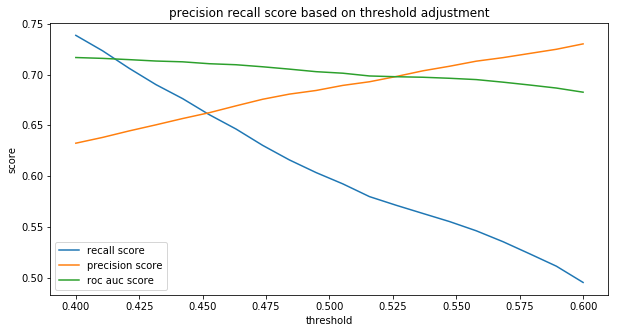

In [511]:
threshold_adjustment_testing_dataset_performance1['recall score'].plot()
threshold_adjustment_testing_dataset_performance1['precision score'].plot()
threshold_adjustment_testing_dataset_performance1['roc auc score'].plot()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title("precision recall score based on threshold adjustment")
plt.legend()
plt.show()

Based on the plot above, 0.4 would be the best threshold to use.

# Plot the feature importance:

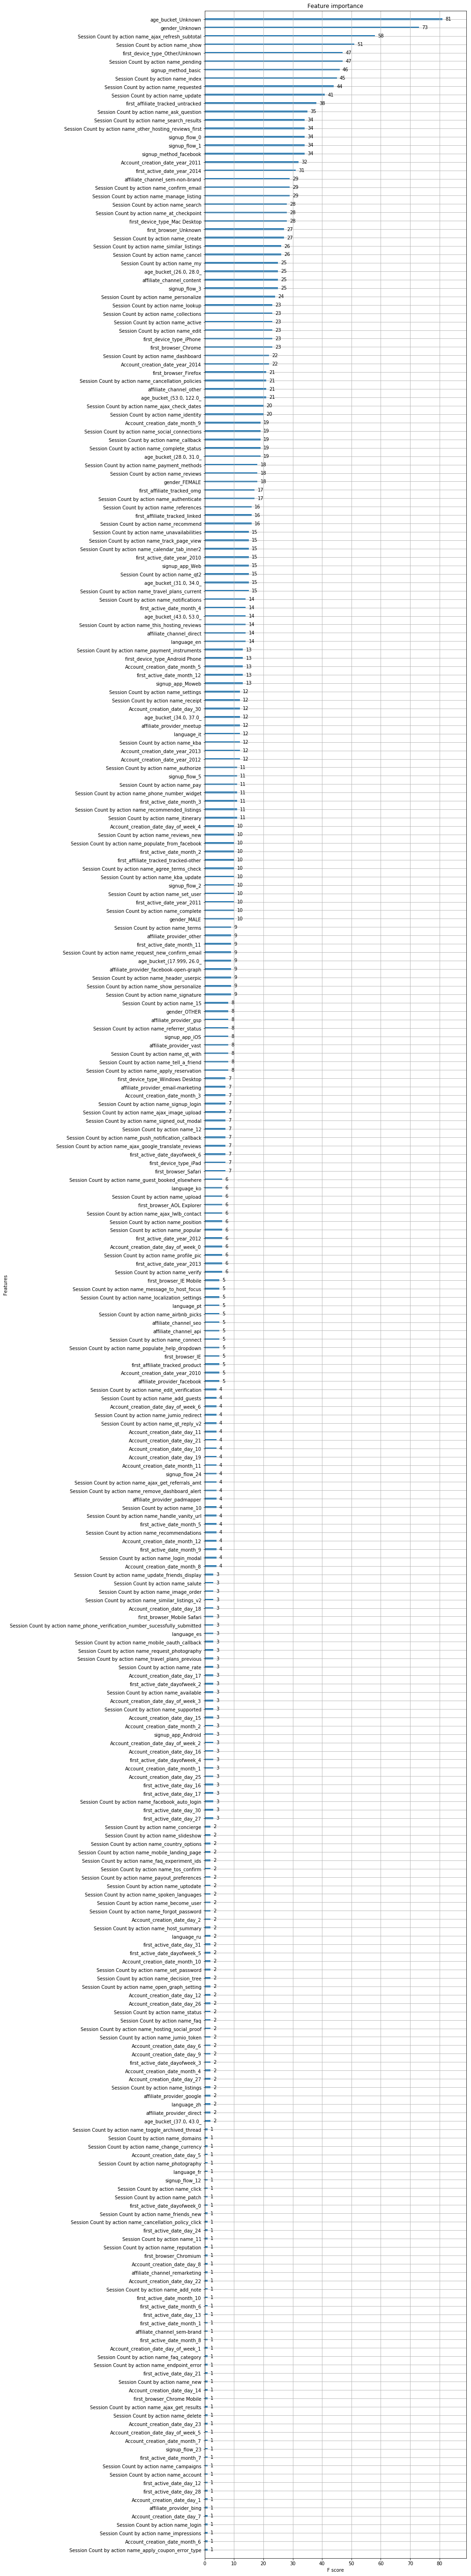

In [276]:
xgb.plot_importance(best_grid)
plt.rcParams['figure.figsize']=[10,200]
plt.show()

# Try Adaboost classifier

# Adaboost Classifier:
- Take the votes from the ensemble to classify the observation
- Exaggerate the weights of the misclassified samples when traning the data

# Drawback:


The algorithm is easily defeated by noisy data. 
The efficiency of the algorithm is highly affected by outliers as the algorithm tries to fit every single data point perfectly.


# Below is the code:

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()

n_estimators = 50 (default value) 

base_estimator = DecisionTreeClassifier (default value)

clf.fit(x_train,y_train)

clf.predict(x_test)

Below is the performance summary of the ada boost classifier:
- Accuracy Score:  71%
- Precision Score:  68%
- Recall Score:  57%
- Roc Auc Score:  69%
- F1 Score:  62%

In [512]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [513]:
y,X=user_training_dataset_update_binary_classfication1.trip_booking_flag, user_training_dataset_update_binary_classfication1[feature_list1]

Seperate out the data into training set (80%) and testing set (20%)

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=111)

In [515]:
%time
score=[]
n_estimators_list=[10, 20, 50, 100, 150]

for n_estimator in n_estimators_list:
    start_time=time.time()
    model_adaboost_binary_clf=AdaBoostClassifier(n_estimators=n_estimator,).fit(X_train,y_train)
    end_time=time.time()
    running_time=end_time-start_time
    y_pred_class= model_adaboost_binary_clf.predict(X_test)
    Accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
    Precision_score=metrics.precision_score(y_test, y_pred_class)
    Recall_score=metrics.recall_score(y_test, y_pred_class)
    f1_score=metrics.f1_score(y_test, y_pred_class)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)

    score.append(dict(n_estimator=n_estimator, accuracy=Accuracy_score, precision=Precision_score, recall=Recall_score, f1=f1_score, roc_auc=roc_auc_score, running_time=running_time))

score=pd.DataFrame(score)       


Wall time: 0 ns


In [516]:
score

,accuracy,f1,n_estimator,precision,recall,roc_auc,running_time
0,0.704504,0.600854,10,0.686303,0.534328,0.680089,16.447574
1,0.706777,0.609374,20,0.683945,0.549465,0.684207,29.418030
2,0.709096,0.622351,50,0.677010,0.575858,0.689980,79.140611
3,0.711133,0.622990,100,0.681995,0.573382,0.691370,150.040900
4,0.711297,0.622523,150,0.682951,0.571919,0.691300,237.097425


Below is the output of the Adaboost classfication model:
- For the adaboost classifier, the more trees you include in the model, the higher precision score, f1 score, roc auc score are
- The more trees you include in the model, the lower the recall score gets
- As in this type of problem, I'm trying to capture as many people who are likely to make the booking as possible. Recall score is very important for the model. I would recommend using 50 as number of trees for the model.

In [517]:
score.columns

Index(['accuracy', 'f1', 'n_estimator', 'precision', 'recall', 'roc_auc',
       'running_time'],
      dtype='object')

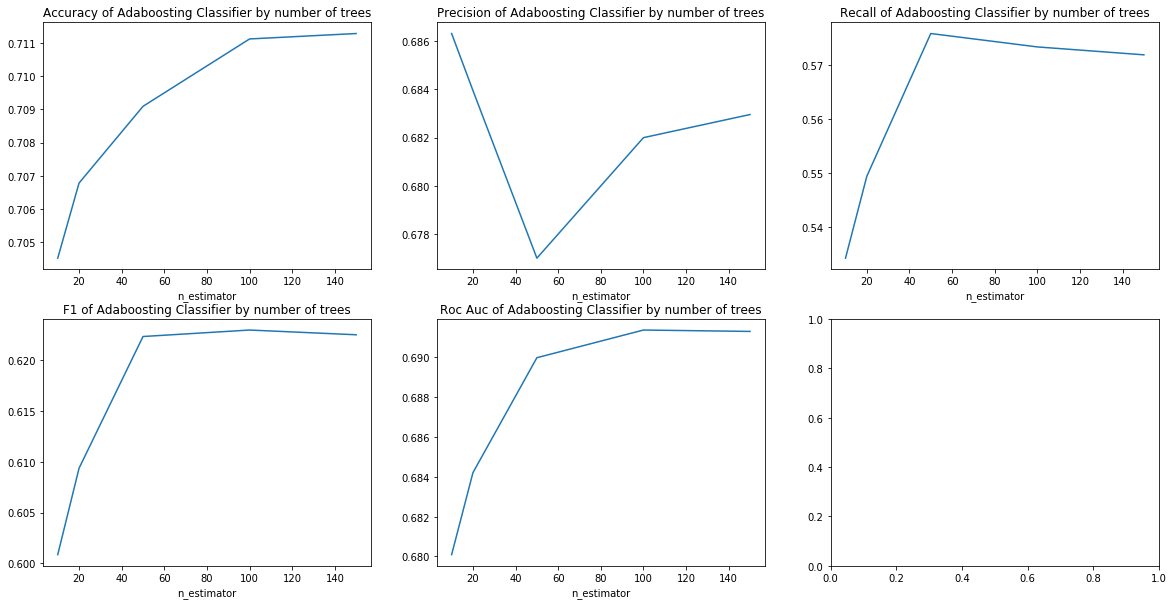

In [518]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
score.groupby(['n_estimator'])['accuracy'].mean().plot(title="Accuracy of Adaboosting Classifier by number of trees",ax =axes[0,0])
score.groupby(['n_estimator'])['precision'].mean().plot(title="Precision of Adaboosting Classifier by number of trees", ax=axes[0,1])
score.groupby('n_estimator')['recall'].mean().plot(title="Recall of Adaboosting Classifier by number of trees", ax=axes[0,2])
score.groupby('n_estimator')['f1'].mean().plot(title="F1 of Adaboosting Classifier by number of trees", ax=axes[1,0])
score.groupby('n_estimator')['roc_auc'].mean().plot(title="Roc Auc of Adaboosting Classifier by number of trees", ax=axes[1,1])

In [519]:
model_adaboost_binary_clf=AdaBoostClassifier(n_estimators=50).fit(X_train,y_train)

Get the roc auc score for the adaboost classification model.

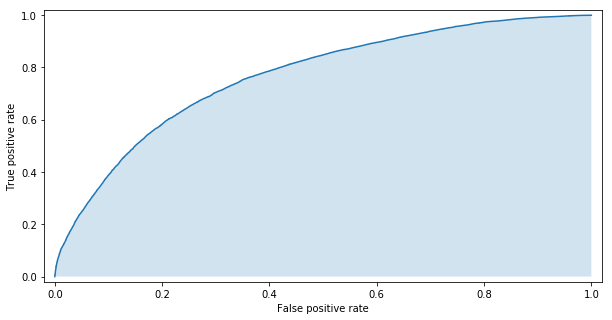

In [520]:
y_pred_proba=np.array(list(zip(*model_adaboost_binary_clf.predict_proba(X_test))))[1]

y_pred_proba
eps = .02
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
f = plt.plot(fpr, tpr)  # plot ROC curve
f = plt.fill_between(fpr, tpr, 0, alpha=.2)  # fill AUC
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)
f = plt.xlabel('False positive rate'), plt.ylabel('True positive rate')


Get the feature importance out of the adaboost model:

In [521]:
Adaboost_feature_importance_df=pd.DataFrame(list(zip(feature_list1 , model_adaboost_binary_clf.feature_importances_)), columns=['Feature Name', 'Feature Importance'])

In [522]:
Adaboost_feature_importance_df.set_index('Feature Name', inplace=True)

In [523]:
Adaboost_feature_importance_df=Adaboost_feature_importance_df.sort_values(by='Feature Importance', ascending=False)

By ranking on the feature importance out of the model, the most import features in the classification would be age_bucket_unknown and numbers of days since account creation as of latest day.

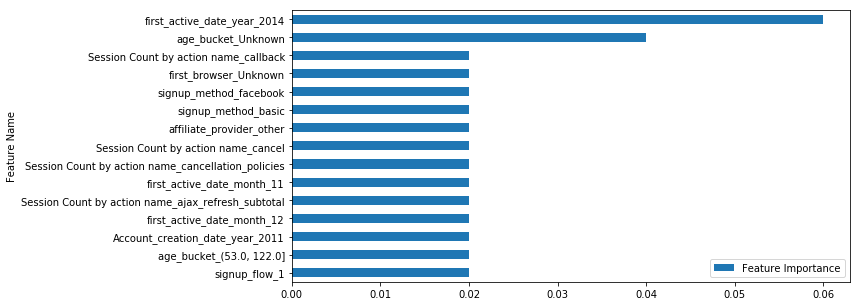

In [524]:
Adaboost_feature_importance_df[:15].sort_values(by='Feature Importance', ascending=True).plot(kind='barh')

# Try Grandient Boosting:

# Below is the code:

from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

n_estimators = 100 (default)

loss function = deviance(default) used in Logistic Regression

clf.fit(x_train,y_train)

clf.predict(x_test)

Below is the performance summary of the gradience boosting classifier:
- Accuracy Score:  71%
- Precision Score:  68%	
- Recall Score:  59%	
- Roc Auc Score:  70%
- F1 Score:  63%	


In [526]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [527]:
y,X=user_training_dataset_update_binary_classfication1.trip_booking_flag, user_training_dataset_update_binary_classfication1[feature_list1]

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=111)

In [529]:
%time
score=[]
n_estimators_list=[10, 20, 50, 100, 150]

for n_estimator in n_estimators_list:
    start_time=time.time()
    model_grandient_boost_binary_clf=GradientBoostingClassifier(n_estimators=n_estimator,).fit(X_train,y_train)
    end_time=time.time()
    running_time=end_time-start_time
    y_pred_class= model_grandient_boost_binary_clf.predict(X_test)
    accuracy_score=metrics.accuracy_score(y_test, y_pred_class)
    precision_score=metrics.precision_score(y_test, y_pred_class)
    recall_score=metrics.recall_score(y_test, y_pred_class)
    f1_score=metrics.f1_score(y_test, y_pred_class)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred_class)

    score.append(dict(n_estimator=n_estimator, accuracy=accuracy_score, precision=precision_score, recall=recall_score, f1=f1_score, roc_auc=roc_auc_score, running_time=running_time))

score=pd.DataFrame(score)       


Wall time: 0 ns


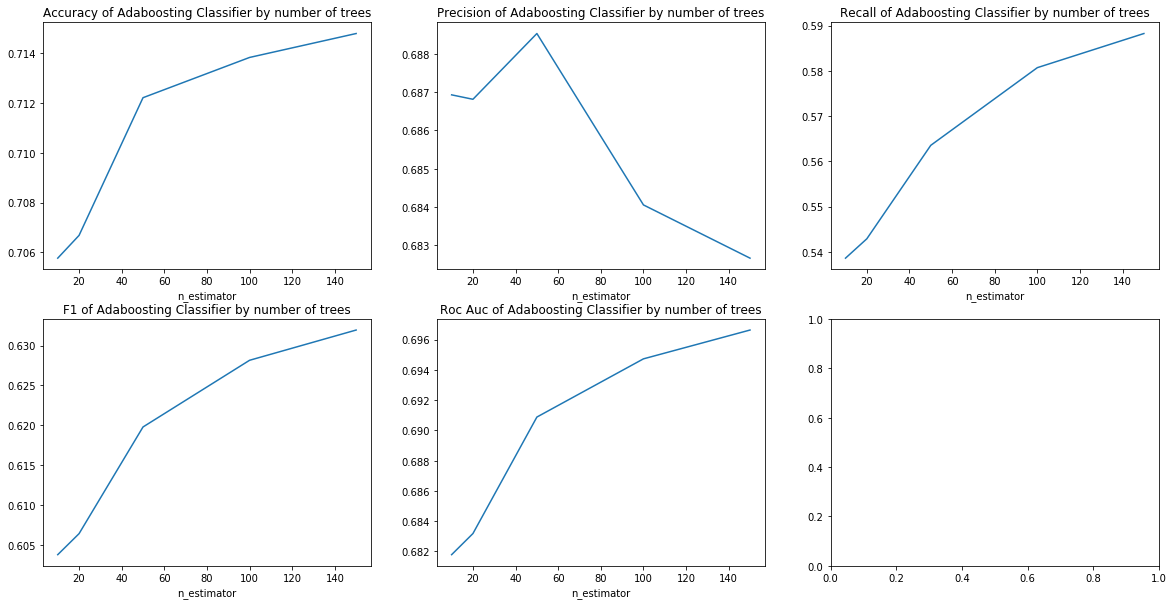

In [530]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
score.groupby(['n_estimator'])['accuracy'].mean().plot(title="Accuracy of Adaboosting Classifier by number of trees",ax =axes[0,0])
score.groupby(['n_estimator'])['precision'].mean().plot(title="Precision of Adaboosting Classifier by number of trees", ax=axes[0,1])
score.groupby('n_estimator')['recall'].mean().plot(title="Recall of Adaboosting Classifier by number of trees", ax=axes[0,2])
score.groupby('n_estimator')['f1'].mean().plot(title="F1 of Adaboosting Classifier by number of trees", ax=axes[1,0])
score.groupby('n_estimator')['roc_auc'].mean().plot(title="Roc Auc of Adaboosting Classifier by number of trees", ax=axes[1,1])

Based on the performance, 150 estimators would be the best number of estimators among the number of estimators selected.

In [531]:
score

,accuracy,f1,n_estimator,precision,recall,roc_auc,running_time
0,0.705769,0.603791,10,0.686930,0.538604,0.681786,69.970970
1,0.706683,0.606424,20,0.686815,0.542881,0.683182,38713.938934
2,0.712211,0.619793,50,0.688531,0.563534,0.690880,203.238039
3,0.713827,0.628154,100,0.684057,0.580698,0.694727,440.459119
4,0.714788,0.631945,150,0.682667,0.588239,0.696631,611.968781


In [532]:
gradient_descent_boosting_df=pd.DataFrame(list(zip(feature_list1, model_grandient_boost_binary_clf.feature_importances_)), columns=['feature name', 'feature importance'])

In [533]:
gradient_descent_boosting_df.set_index('feature name', inplace=True)

In [534]:
gradient_descent_boosting_df.sort_values(by='feature importance', ascending=False, inplace=True)

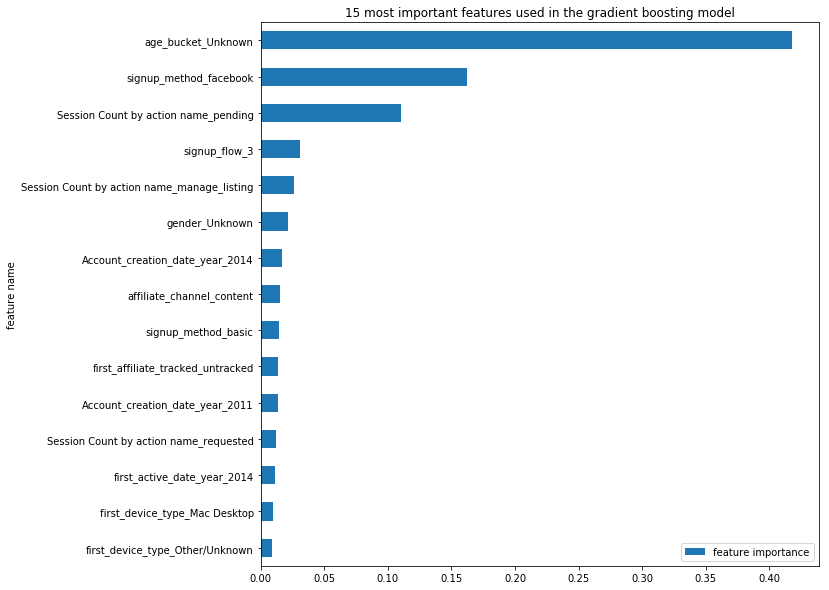

In [535]:
plt.rcParams['figure.figsize']=[10,10]
gradient_descent_boosting_df[:15].sort_values(by='feature importance', ascending=True).plot(kind='barh', title="15 most important features used in the gradient boosting model")

plt.show()

# By comparing all the models that have been used above, the random forest classifier is performing relatively better.

# Export the training data set sample file into csv:

In [77]:
X_train.head().to_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/user_training_dataset_sample.csv")

# Use Kaggle testing data to make the prediction using the random forest classfier:

In [84]:
X_TEST_Kaggle=pd.read_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/testing_dataset_for_binary_classification.csv")

In [94]:
del X_TEST_Kaggle['Unnamed: 0']

In [89]:
X_TEST_Kaggle.set_index('id', inplace=True)

In [98]:
X_TEST_Kaggle_prediction=best_grid_search_random_forest.predict(X_TEST_Kaggle)

In [111]:
X_TEST_Kaggle_prediction_proba=best_grid_search_random_forest.predict_proba(X_TEST_Kaggle)

In [129]:
X_TEST_Kaggle_prediction_proba_list=list(zip(*X_TEST_Kaggle_prediction_proba))[1]

Use 0.442 as threshold for X_TEST_Kaggle_prediction:

In [130]:
X_TEST_Kaggle_prediction1=pd.Series(X_TEST_Kaggle_prediction_proba_list)>=0.442105

In [131]:
pd.DataFrame(X_TEST_Kaggle_prediction1)[0].value_counts()

True     37298
False    24798
Name: 0, dtype: int64

In [134]:
X_TEST_Kaggle_1=X_TEST_Kaggle.reset_index()

In [135]:
X_TEST_Kaggle_1.head()

,id,Total time spent (in seconds)_fill_null_zero,session count_fill_null_zero,Session Count by action name_10,Session Count by action name_11,Session Count by action name_12,Session Count by action name_15,Session Count by action name_about_us,Session Count by action name_accept_decline,Session Count by action name_account,...,first_active_date_year_2013,first_active_date_month_1,first_active_date_month_2,first_active_date_month_3,first_active_date_month_4,first_active_date_month_5,first_active_date_month_6,first_active_date_month_10,first_active_date_month_11,first_active_date_month_12
0,5uwns89zht,119187.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,jtl0dijy2j,250119.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,xx0ulgorjt,975575.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,6c6puo6ix0,123001.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,czqhjk3yfe,454023.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
X_TEST_Kaggle_1=pd.merge(X_TEST_Kaggle_1, pd.DataFrame(X_TEST_Kaggle_prediction1), left_index=True, right_index=True)

In [144]:
X_TEST_Kaggle_1= X_TEST_Kaggle_1[[X_TEST_Kaggle_1.columns[0], X_TEST_Kaggle_1.columns[-1]]]

In [147]:
X_TEST_Kaggle_1.rename(columns={0:'Prediction'}, inplace=True)

C:\Users\yuka.abe\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# Output the user id with "NDF" destination

In [155]:
X_TEST_Kaggle_1.to_csv("C:/Users/yuka.abe/Desktop/Airbnb Kaggle DataSet/kaggle_testing_data_prediction_with_NDF_destination.csv")